In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import annotations

import logging

import numpy as np
from scipy.io import readsav

from mhsxtrapy.b3d import WhichSolution
from mhsxtrapy.field2d import (
    Field2dData,
    FluxBalanceState,
    alpha_HS04,
    check_fluxbalance,
)
from mhsxtrapy.field3d import calculate_magfield
from mhsxtrapy.plotting.vis import (
    plot_ddensity_xy,
    plot_ddensity_z,
    plot_dpressure_xy,
    plot_dpressure_z,
    plot_magnetogram_2D,
    plot_magnetogram_3D,
)

The following packages are not installed:
['mpl-animators>=1.0.0', 'reproject>=0.9.0']
To install sunpy with these dependencies use `pip install sunpy[map]` or `pip install sunpy[all]` for all extras. 
If you installed sunpy via conda, please report this to the community channel: https://matrix.to/#/#sunpy:openastronomy.org [sunpy.util.sysinfo]
The following packages are not installed:
['mpl-animators>=1.0.0']
To install sunpy with these dependencies use `pip install sunpy[visualization]` or `pip install sunpy[all]` for all extras. 
If you installed sunpy via conda, please report this to the community channel: https://matrix.to/#/#sunpy:openastronomy.org [sunpy.util.sysinfo]
/Users/lilli/Library/Caches/pypoetry/virtualenvs/mhsxtrapy-_witMKZG-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Example for magnetic field extrapolation from semi-analytical boundary condition instantiated through .sav file and using Hagino and Sakurai (2004) for determination of $\alpha$

##### LOW AND LOU (1990) EXAMPLE 

Low & Lou (1990) describe a method to construct theoretical examples of semi-analytical non-linear force-free fields. 
The model is referred to as semi-analytical, as it is analytical except for the numerical solution of an ordinary differential equation in one coordinate direction. The overall solution depends on parameters usually called n and m. For details we refer to the original paper (see Low and Lou 1990). Because the full solution is known these fields can be used for testing the reliability and accuracy of non-linear force-free extrapolation methods by imposing 
full vector boundary conditions taken from the Low and Lou (1990) solution. As such, this method has been used recently for testing of non-linear force-free models in e.g. Schrijver et al. (2006) and Jarolim et al. (2023) and for testing of an MHS model in Zhu and Wiegelmann (2018).

Although our extrapolation methods only require boundary conditions for B_z, one can use information about the horizontal magnetic field components at z = 0 to constrain the constant alpha using the method of Hagino and Sakurai (2004). For the Low and Lou (1990) field all magnetic field components on the boundary are known and hence one 
can apply the method. The existence of such solutions is somewhat equivalent to vector magnetograph data being available instead of, exclusively, the line-of-sight magnetic field component.

The solutions by Low and Lou (1990), which are simple in structure and axisymmetric, are constructed as follows: a dipole-like point source including field-aligned currents is placed at (0, 0, -l) below the origin of the physical coordinate system (x, y, z). Then, the local coordinate system (X, Y, Z), in which the dipole lies, is orientated at an 
angle to (x, y, z). The rotation is carried out in the X-Z-plane in relation to the x-z-plane, such that 0 < φ < π/2 is the angle between the z-axis and the Z-axis. Extrapolation is carried out in the z > 0 domain, as the photosphere is taken to be located in the x-y-plane at z = 0.

The line-of-sight magnetogram used as the boundary condition to mimic the photospheric magnetic field in this example is a slice extracted from the non-linear force-free model described above. The parameters n = 1,m = 1, l = 0.3 and φ = 0.47 have been used for this purpose (Low and Lou 1990), and lead to the magnetogram consisting of one sink and one extended source. The structure of this boundary condition can be seen in Figure 7.8. The size of the bottom boundary domain corresponds to 3.2 Mm in both x- and y-direction with resolution of 0.04 Mm pixel^-1 in all directions, which is a pixel size comparable, for example, to Sunrise/IMaX observations. The magnetic field strength on the boundary varies from -1792 G to 446 G.

The .sav file containing the boundary condition was provided by the ISSI team "Magnetohydrostatic Modeling of the Solar Atmosphere with New Datasets" (https://teams.issibern.ch/magnetohydrostaticsolaratmosphere/) and can be found in the folder EXAMPLE-Low-Lou/data.

##### Load data from file

In [3]:
path = "data/Analytic_boundary_data.sav"

data = readsav(path, python_dict=True, verbose=True)

--------------------------------------------------
Date: Tue Sep  6 15:16:46 2022
User: xszhu
Host: HR30
--------------------------------------------------
Format: 9
Architecture: x86_64
Operating System: linux
IDL Version: 7.1.1
--------------------------------------------------
Successfully read 33 records of which:
 - 29 are of type VARIABLE
 - 1 are of type NOTICE
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
--------------------------------------------------
Available variables:
 - b2dx1 [<class 'numpy.ndarray'>]
 - b2dy1 [<class 'numpy.ndarray'>]
 - b2dz1 [<class 'numpy.ndarray'>]
 - d2d1 [<class 'numpy.ndarray'>]
 - b2dx2 [<class 'numpy.ndarray'>]
 - b2dy2 [<class 'numpy.ndarray'>]
 - b2dz2 [<class 'numpy.ndarray'>]
 - d2d2 [<class 'numpy.ndarray'>]
 - b2dx3 [<class 'numpy.ndarray'>]
 - b2dy3 [<class 'numpy.ndarray'>]
 - b2dz3 [<class 'numpy.ndarray'>]
 - d2d3 [<class 'numpy.ndarray'>]
 - b2dx4 [<class 'numpy.ndarray'>]
 - b2dy4 [<class 'numpy.ndarray'>]
 - b2dz4 [<class '

##### Read information from file

In [4]:
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

info_array = data.get("info_array")
logging.info(f"Info Array: {info_array}")


info_boundary = data.get("info_boundary")
logging.info(f"Info Boundary: {info_boundary}")


info_pixel = data.get("info_pixel")
logging.info(f"Info Pixel: {info_pixel}")


info_unit = data.get("info_unit")
logging.info(f"Info Unit: {info_unit}")

2025-05-04 11:56:00,781 - INFO - Info Array: b'Array example: d2d1(ny,nz), d2d2(ny,nz), d2d3(nx,nz), d2d4(nx,nz), d2d5(nx,ny), d2d6(nx,ny), h3d(nx,ny,nz)'
2025-05-04 11:56:00,787 - INFO - Info Boundary: b'Boundary index 1: x=0; 2: x=xmax; 3: y=0; 4: y=ymax; 5: z=0; 6: z=zmax'
2025-05-04 11:56:00,789 - INFO - Info Pixel: b'Pixel size: 40km*40km*40km'
2025-05-04 11:56:00,793 - INFO - Info Unit: b'b2d, d2d, h3d: magnetic vector (Gauss), plasma density (g/cm^3), scale height (km)'


##### Instantiate relevant parameters

In [5]:
data_bz = data[
    "b2dz5"
]  # Read magnetic field data in Gauss, see "Info Array" and "Info Unit" above.
data_bx = data["b2dx5"]
data_by = data["b2dy5"]

nx = data_bz.shape[1]
ny = data_bz.shape[0]

pz = (
    40.0 * 10**-3
)  # Convert pixelsize from km into Mm, see "Info Pixel" in previous cell.
px = 40.0 * 10**-3
py = 40.0 * 10**-3

xmin, ymin, zmin = 0.0, 0.0, 0.0
xmax = nx * px
ymax = ny * py
zmax = 4000.0 * 10**-3

nz = int(np.floor(zmax / pz))

nf = min(nx, ny)

x_arr = np.linspace(xmin, xmax, nx, dtype=np.float64)
y_arr = np.linspace(ymin, ymax, ny, dtype=np.float64)
z_arr = np.linspace(zmin, zmax, nz, dtype=np.float64)

##### Check if flux through boundary condition is balanced 

check_fluxbalance returns the summation of the flux through the bottom boundary, normalised by the sum of absolute values. 
This returns a value between −1 and 1, where either extreme corresponds to the flux being directed entirely inward or entirely outward, respectively. We consider values 
between −0.01 and 0.01 as flux-balanced in agreement with Wiegelmann & Sakurai (2021). 

In [6]:
np.fabs(check_fluxbalance(data_bz)) < 0.01

True

##### Instantiate Field2dData object from Low and Lou boundary condition 

In [7]:
data2d = Field2dData(
    nx,
    ny,
    nz,
    nf,
    px,
    py,
    pz,
    x_arr,
    y_arr,
    z_arr,
    data_bz,
    flux_balance_state=FluxBalanceState.BALANCED,
)

##### Plot 2D boundary condition

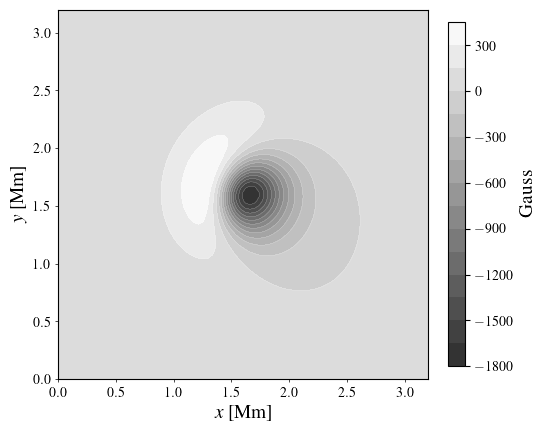

In [8]:
plot_magnetogram_2D(data2d)

##### Calculate $\alpha$ based on Hagino and Sakurai (2004)

"Optimal" alpha calculated according to Hagino and Sakurai (2004). Alpha is calculated from the vertical electric current in the photosphere (from horizontal photospheric field) 
and the photospheric vertical magnetic field.

In [9]:
alpha_HS04(data_bx, data_by, data_bz)

-0.037860297

##### Extrapolate magnetic field

In [10]:
data3d = calculate_magfield(
    data2d,
    alpha=-0.03,
    a=0.27,
    which_solution=WhichSolution.ASYMP,
    b=1.0,
    z0=2.0,
    deltaz=0.2,
)

In [11]:
J = data3d.j3D

In [12]:
B = data3d.field

In [13]:
num = np.zeros((B.shape[0], B.shape[1], B.shape[2]))
den = np.zeros_like(num)

In [14]:
for i in range(B.shape[0]):
    for j in range(B.shape[1]):
        for k in range(B.shape[2]):
            num = np.dot(J[i,j,k], B[i,j,k])
            den = np.dot(B[i,j,k], B[i,j,k])

In [15]:
J_orthogonal = J - num/den * B

In [16]:
import matplotlib.pyplot as plt

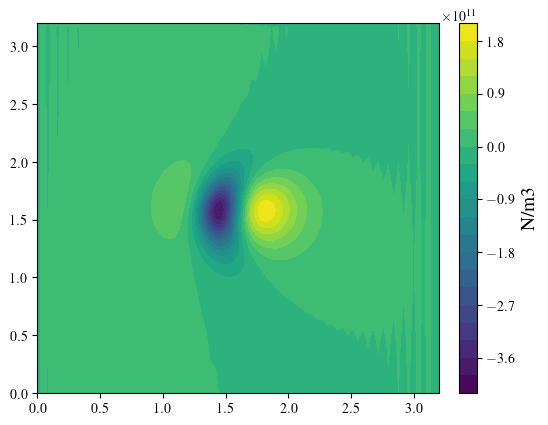

In [17]:
fig = plt.figure()
ax = fig.figure.add_subplot(111)  # type: ignore
x_grid, y_grid = np.meshgrid(data3d.x, data3d.y)
C = ax.contourf(
    x_grid,
    y_grid,
    J[:, :, 0, 1],
    20,
    # offset=0.0,
)
cbar = fig.colorbar(
        C, ax=ax, pad=0.04
    )  # Adjust pad as necessary
cbar.set_label(r"N/m3", fontsize=14)
plt.show()

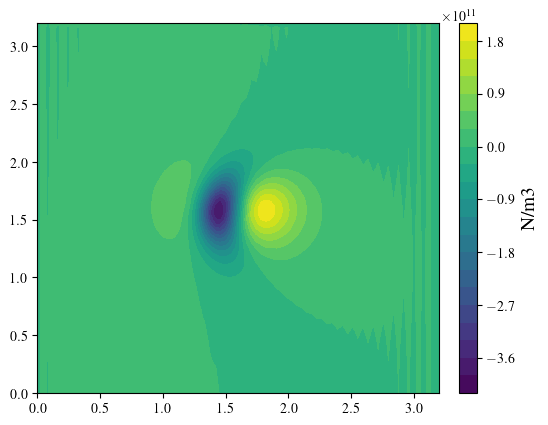

In [18]:
fig = plt.figure()
ax = fig.figure.add_subplot(111)  # type: ignore
x_grid, y_grid = np.meshgrid(data3d.x, data3d.y)
C = ax.contourf(
    x_grid,
    y_grid,
    J_orthogonal[:, :, 0, 1],
    20,
    # offset=0.0,
)
cbar = fig.colorbar(
        C, ax=ax, pad=0.04
    )  # Adjust pad as necessary
cbar.set_label(r"N/m3", fontsize=14)
plt.show()

##### Plot

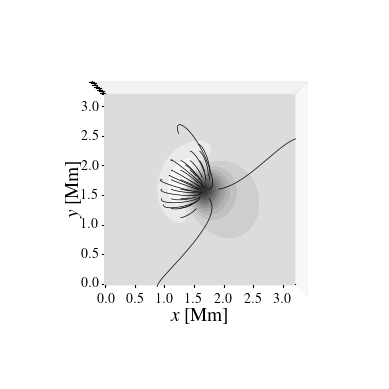

In [20]:
plot_magnetogram_3D(data3d, view="los", footpoints="active-regions")

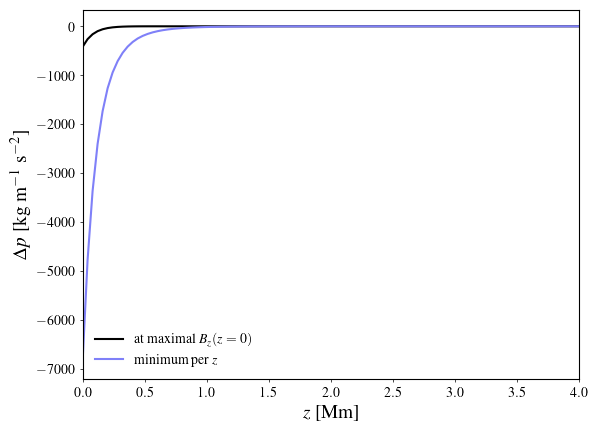

In [21]:
plot_dpressure_z(data3d)

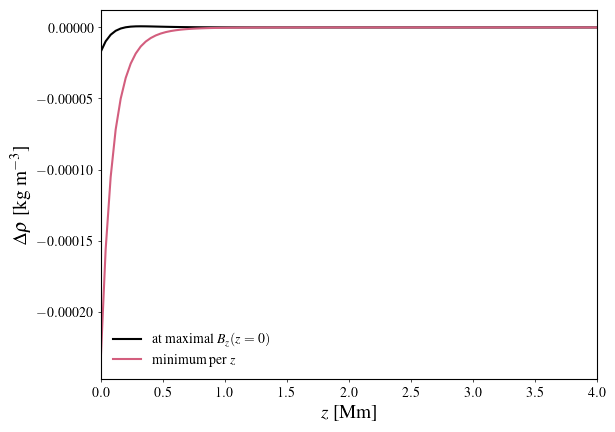

In [22]:
plot_ddensity_z(data3d)

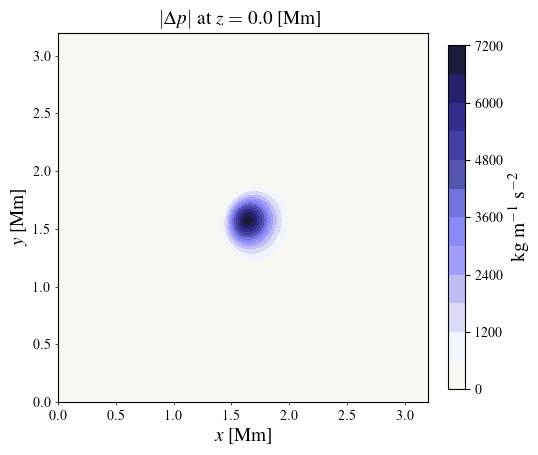

In [23]:
plot_dpressure_xy(data3d, 0)

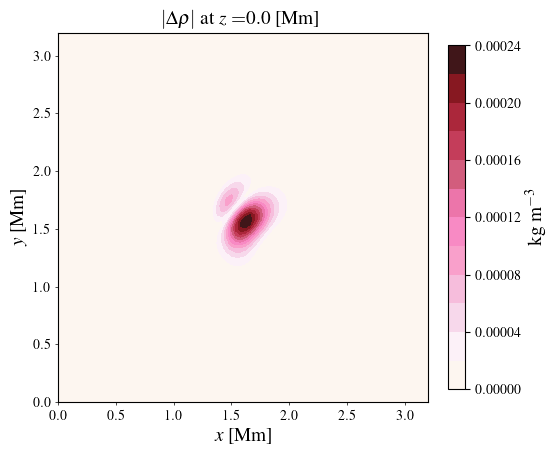

In [24]:
plot_ddensity_xy(data3d, 0)